# Publication-Ready Visualizations for TEACH AI Evaluator Analysis

This notebook generates publication-quality visualizations for the manuscript analyzing AI-based TEACH classroom observation evaluators. All figures are formatted for academic journal publication with professional styling and color schemes appropriate for education research.

**Author:** Matt Krasnow
**Date:** June 2025  
**Version:** 1.0

## Contents
1. Environment Setup & Data Loading
2. Domain-Level Accuracy Analysis (Strict & Loose)
3. Reliability Exam Performance Analysis
4. Statistical Significance Visualizations
5. Model Specifications Table
6. Export All Figures for Publication

## 1. Environment Setup & Data Loading

In [63]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import json
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plotting parameters
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)

# Define professional color palette for education journal
# Using a colorblind-friendly palette
COLOR_PALETTE = [
    '#0173B2',  # Blue
    '#DE8F05',  # Orange
    '#029E73',  # Green
    '#CC78BC',  # Light Purple
    '#CA9161',  # Brown
    '#949494'   # Gray
]

# Set color palette
sns.set_palette(COLOR_PALETTE)

print("Environment setup complete. Publication-quality parameters loaded.")

Environment setup complete. Publication-quality parameters loaded.


In [ ]:
# Define paths and load data
ROOT_DIR = Path('.')
EVAL_DIR = ROOT_DIR / 'new' / 'rawData' / 'Peru' / 'model_evaluation_data'
HUMAN_FILE = ROOT_DIR / 'new' / 'formattedData' / 'test_only_peru_cleaned_transcripts.csv'

# Load human reference data
human_df = pd.read_csv(HUMAN_FILE)

DOMAIN_COLS = [
    'Supportive Learning Environment',
    'Positive Behavioral Expectations',
    'Lesson Facilitation',
    'Checks for understanding',
    'Feedback',
    'Critical Thinking',
    'Autonomy',
    'Perseverance',
    'Social & Collaborative Skills',
] # excludes ToL

# Load all evaluator results
eval_paths = sorted(EVAL_DIR.glob('*_evaluations.csv'))
print(f"Found {len(eval_paths)} evaluator files")

Found 6 evaluator files


In [72]:
# Helper functions for data processing
_LETTER_TO_INT = {'L': 1, 'M': 2, 'H': 3, 'Y': 1, 'N': 0, '': np.nan, np.nan: np.nan}

def _as_numeric(x):
    """Convert rubric value to numeric for distance calculation."""
    if pd.isna(x):
        return np.nan
    try:
        return float(x)
    except ValueError:
        return _LETTER_TO_INT.get(str(x).strip(), np.nan)

def domain_pass(model_val, human_val):
    """Check if domain passes (within 1 point)."""
    mv = _as_numeric(model_val)
    hv = _as_numeric(human_val)
    if pd.isna(mv) or pd.isna(hv):
        return False
    return abs(mv - hv) <= 1

def compute_domain_accuracies(model_df, human_df, domain_col):
    """Compute strict and loose accuracy for a domain."""
    merged = model_df.merge(human_df, on='School_Clip', suffixes=('_model', '_human'))
    
    strict_matches = 0
    loose_matches = 0
    total = 0
    
    for _, row in merged.iterrows():
        model_val = row[f'{domain_col}_model']
        human_val = row[f'{domain_col}_human']
        
        if pd.isna(human_val):
            continue
            
        total += 1
        
        # Strict accuracy: exact match
        if model_val == human_val:
            strict_matches += 1
            
        # Loose accuracy: within 1 point
        if domain_pass(model_val, human_val):
            loose_matches += 1
    
    strict_acc = strict_matches / total if total > 0 else 0
    loose_acc = loose_matches / total if total > 0 else 0
    
    return strict_acc, loose_acc

print("Helper functions loaded.")

Helper functions loaded.


## 2. Domain-Level Accuracy Analysis (Strict & Loose)

This section creates stacked bar charts showing:
- **Strict Accuracy**: Exact agreement between AI and human evaluators
- **Within-One Accuracy**: Agreement within one normalized unit (formerly "loose accuracy")

In [77]:
# Compute domain accuracies for all models
model_names = []
domain_results = {domain: {'strict': [], 'within_one': []} for domain in DOMAIN_COLS}

for eval_path in eval_paths:
    model_name = eval_path.stem.replace('_evaluations', '')
    model_names.append(model_name)
    model_df = pd.read_csv(eval_path)
    
    for domain in DOMAIN_COLS:
        strict, loose = compute_domain_accuracies(model_df, human_df, domain)
        domain_results[domain]['strict'].append(strict)
        domain_results[domain]['within_one'].append(loose)

# Create simplified model names for publication
model_labels = [
    'Control',
    'Base',
    'Medium\nRubric',
    'High\nRubric',
    'High Rubric\n+ Reasoning',
    'High Rubric\n+ Timestamps'
]

print(f"Computed accuracies for {len(model_names)} models across {len(DOMAIN_COLS)} domains.")

Computed accuracies for 6 models across 9 domains.


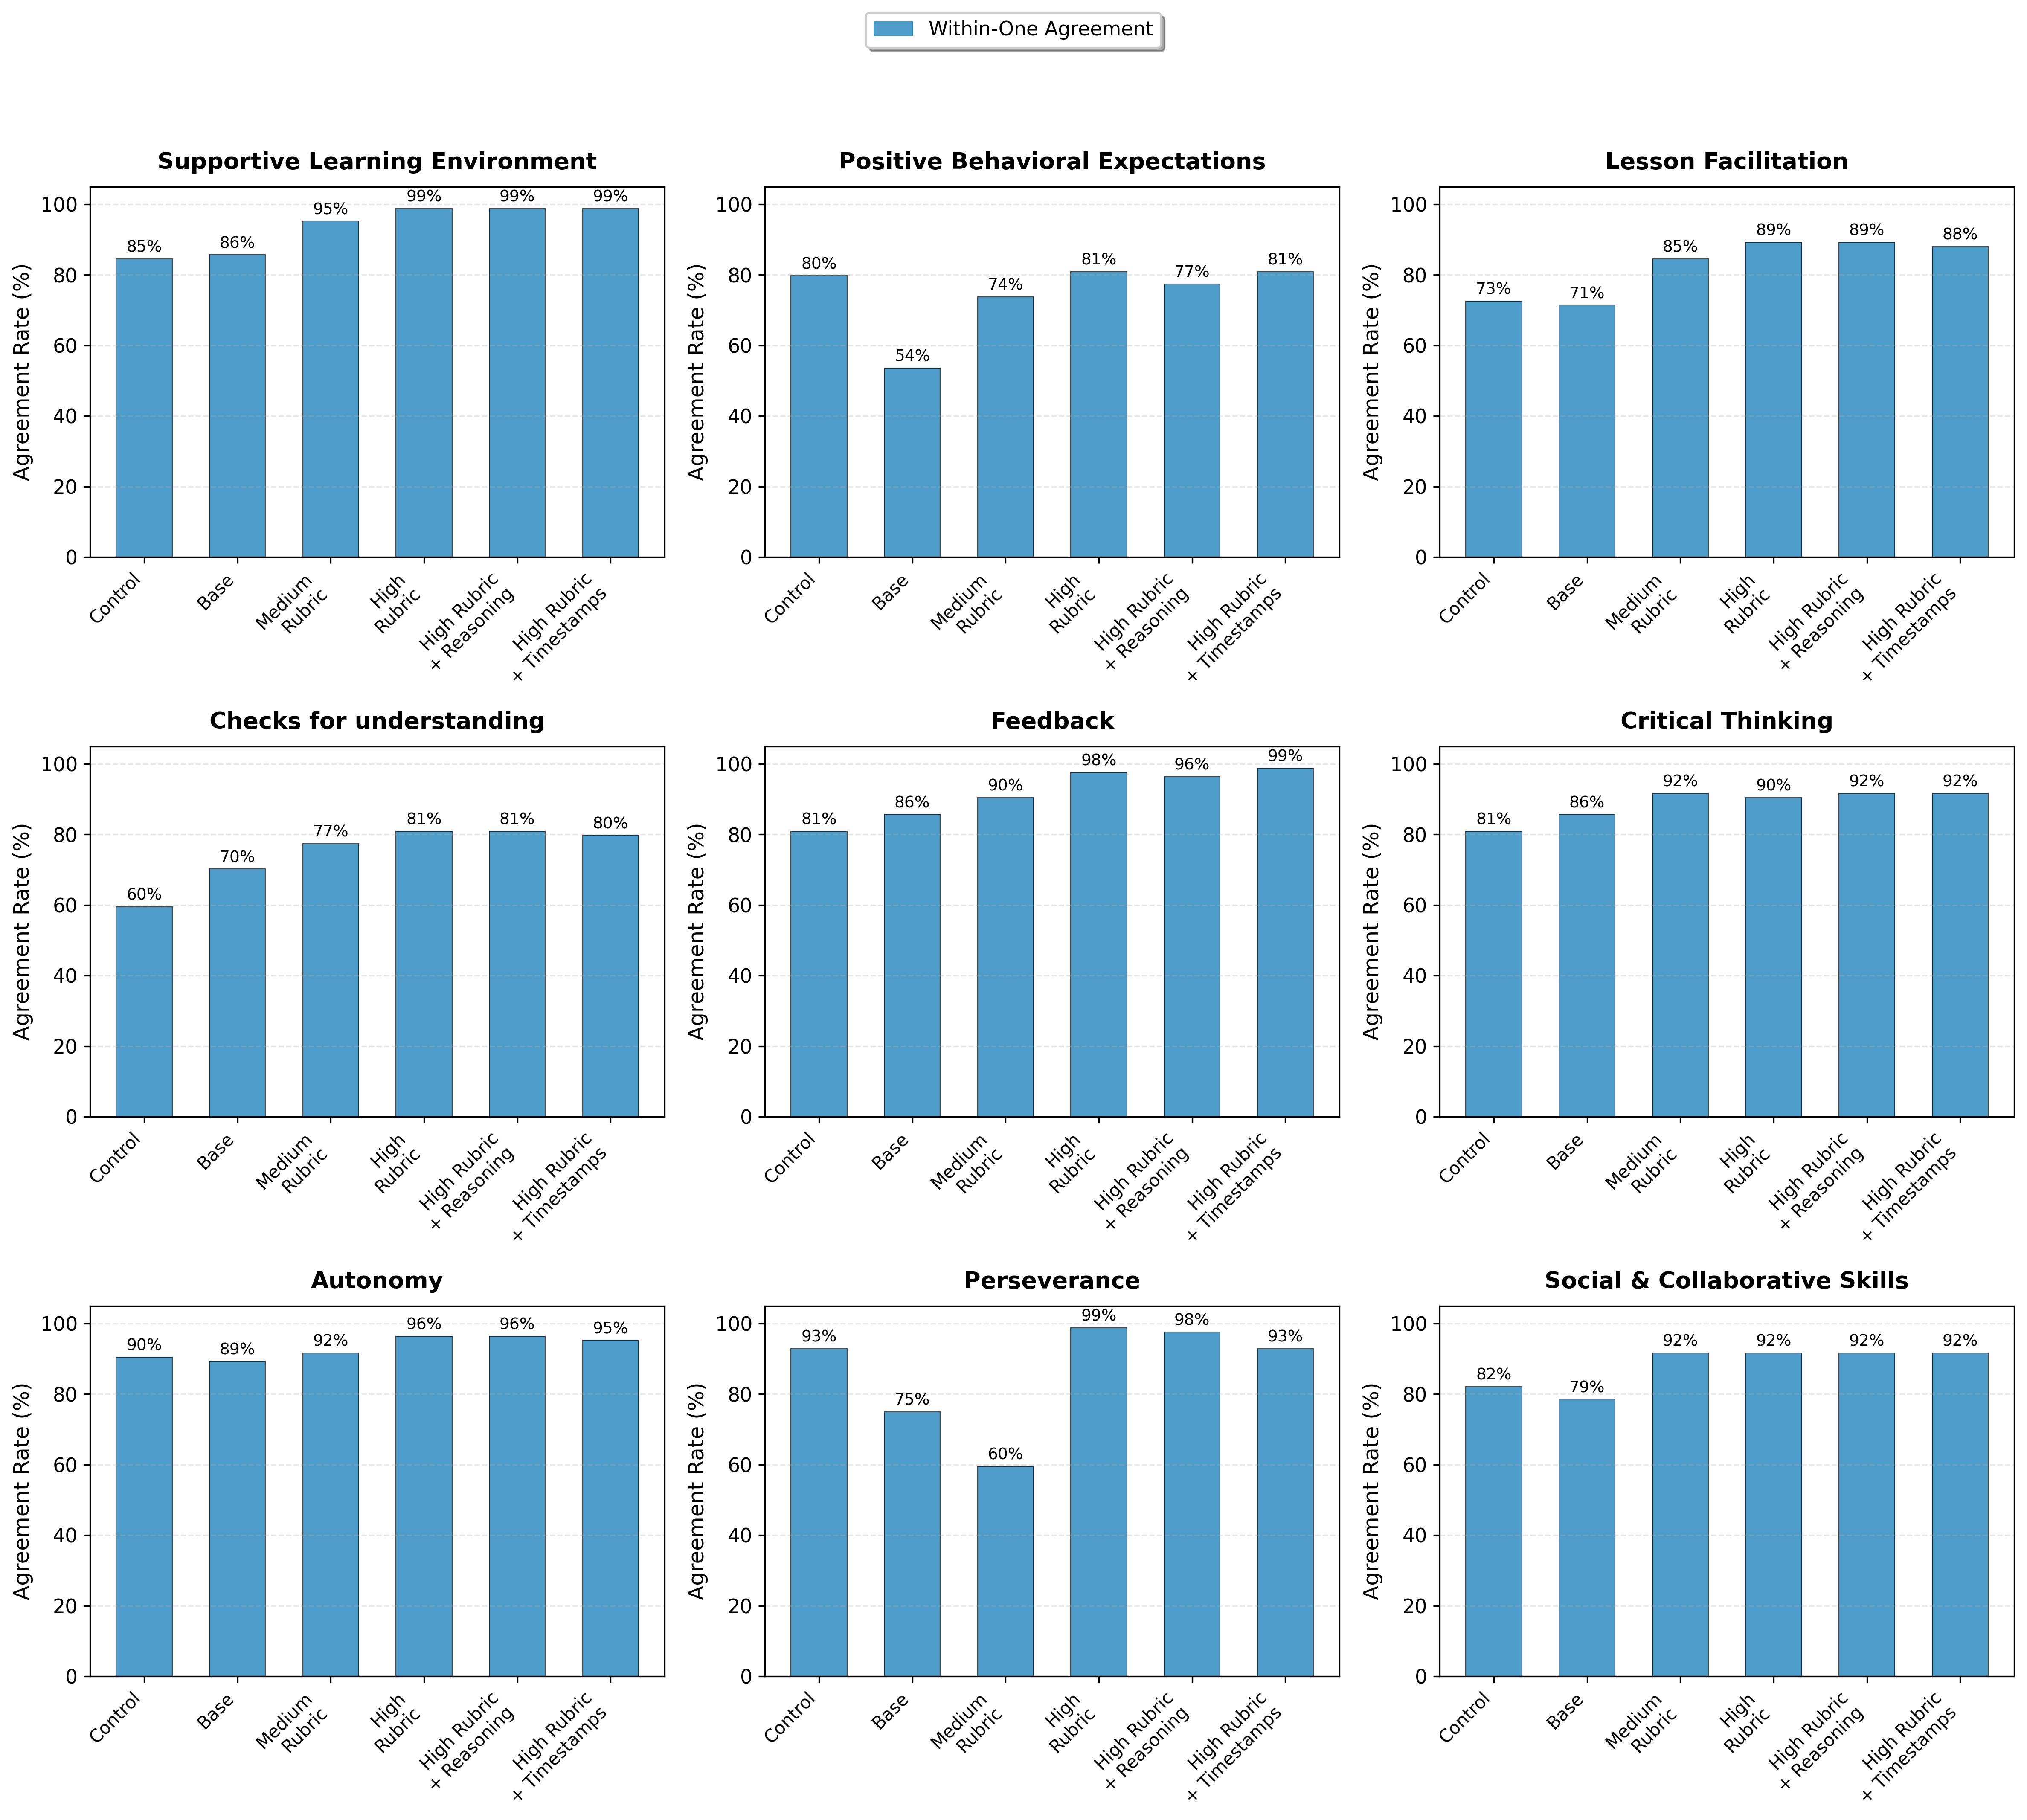

Domain within-one visualization saved as 'domain_accuracy_analysis.pdf' and '.png'


In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes DOMAIN_COLS, model_labels, domain_results, and COLOR_PALETTE are defined above

# Create domain within-one visualization
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

for idx, domain in enumerate(DOMAIN_COLS):
    ax = axes[idx]
    x = np.arange(len(model_labels))
    width = 0.6

    within_one_vals = np.array(domain_results[domain]['within_one']) * 100

    ax.bar(
        x,
        within_one_vals,
        width,
        label='Within-One Agreement',
        color=COLOR_PALETTE[0],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7
    )

    ax.set_ylabel('Agreement Rate (%)', fontsize=12)
    ax.set_title(domain, fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=10)
    ax.set_ylim(0, 105)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    for i, val in enumerate(within_one_vals):
        if val > 5:
            ax.text(
                i,
                val + 1,
                f'{val:.0f}%',
                ha='center',
                va='bottom',
                fontsize=9
            )

# Gather a single legend handle/label for within-one agreement
handle = plt.Rectangle((0, 0), 1, 1, color=COLOR_PALETTE[0], edgecolor='black', linewidth=0.5, alpha=0.7)
label = 'Within-One Agreement'

# Place a single legend above all subplots
fig.legend(
    [handle],
    [label],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=1,
    frameon=True,
    fancybox=True,
    shadow=True
)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and show
plt.savefig('domain_accuracy_analysis.pdf', bbox_inches='tight', dpi=300)
plt.savefig('domain_accuracy_analysis.png', bbox_inches='tight', dpi=300)
plt.show()

print("Domain within-one visualization saved as 'domain_accuracy_analysis.pdf' and '.png'")


## 3. Reliability Exam Performance Analysis

This section analyzes performance on the TEACH reliability exam, showing:
- Segment pass rates with threshold line
- First-try and two-try certification probabilities
- Detailed performance table

In [78]:
# --- Reliability-exam metric helpers (UPDATED v2 — typo fixed) ----------------
import numpy as np

def segment_reliable(row_m, row_h, threshold: int = 8):
    """
    A segment is reliable when at least `threshold` of the 9 TEACH domain
    elements agree (within-one point).  Threshold 8 keeps the ≥80 % bar that
    previously required 8/10 elements (ToL now removed).
    """
    agree = 0
    for col in DOMAIN_COLS:
        agree += int(domain_pass(row_m[col], row_h[col]))
    return agree >= threshold


def simulate_exam(seg_passes: np.ndarray,
                  n_iter: int = 10_000,
                  seed: int = 42) -> tuple[float, float]:
    """
    Monte-Carlo probability of passing a three-segment exam in ≤2 attempts,
    using *only* segment-level reliability (no Time-on-Learning component).
    """
    rng = np.random.default_rng(seed)
    if len(seg_passes) < 3:
        return np.nan, np.nan

    first, second = 0, 0
    idx_all = np.arange(len(seg_passes))

    for _ in range(n_iter):
        first_set = rng.choice(idx_all, 3, replace=False)
        if seg_passes[first_set].all():
            first += 1
            second += 1
            continue

        remain = np.setdiff1d(idx_all, first_set, assume_unique=True)
        if len(remain) < 3:
            continue
        second_set = rng.choice(remain, 3, replace=False)
        if seg_passes[second_set].all():
            second += 1

    return first / n_iter, second / n_iter
# -----------------------------------------------------------------------------


# ---------- Compute reliability metrics (segment-only) ------------------------
reliability_results = []

for eval_path, mdl_lbl in zip(eval_paths, model_labels):
    df_m   = pd.read_csv(eval_path)
    mdl_id = mdl_lbl.replace('\n', ' ')

    merged = df_m.merge(human_df, on='School_Clip', suffixes=('_model', '_human'))

    seg_ok = []
    for _, row in merged.iterrows():
        row_m = row[[c + '_model' for c in DOMAIN_COLS]]
        row_h = row[[c + '_human' for c in DOMAIN_COLS]]
        row_m.index = DOMAIN_COLS
        row_h.index = DOMAIN_COLS
        seg_ok.append(segment_reliable(row_m, row_h))

    seg_ok = np.array(seg_ok, dtype=bool)

    seg_pass_rate  = seg_ok.mean() if seg_ok.size else np.nan
    p_first, p_two = simulate_exam(seg_ok)

    reliability_results.append({
        'Model'            : mdl_id,
        'Segment Pass Rate': seg_pass_rate,
        'First Try Prob'   : p_first,
        'Two Try Prob'     : p_two          # ← fixed column name
    })

reliability_df = pd.DataFrame(reliability_results)
print("✅ Re-computed segment-only reliability metrics (ToL removed).")


✅ Re-computed segment-only reliability metrics (ToL removed).


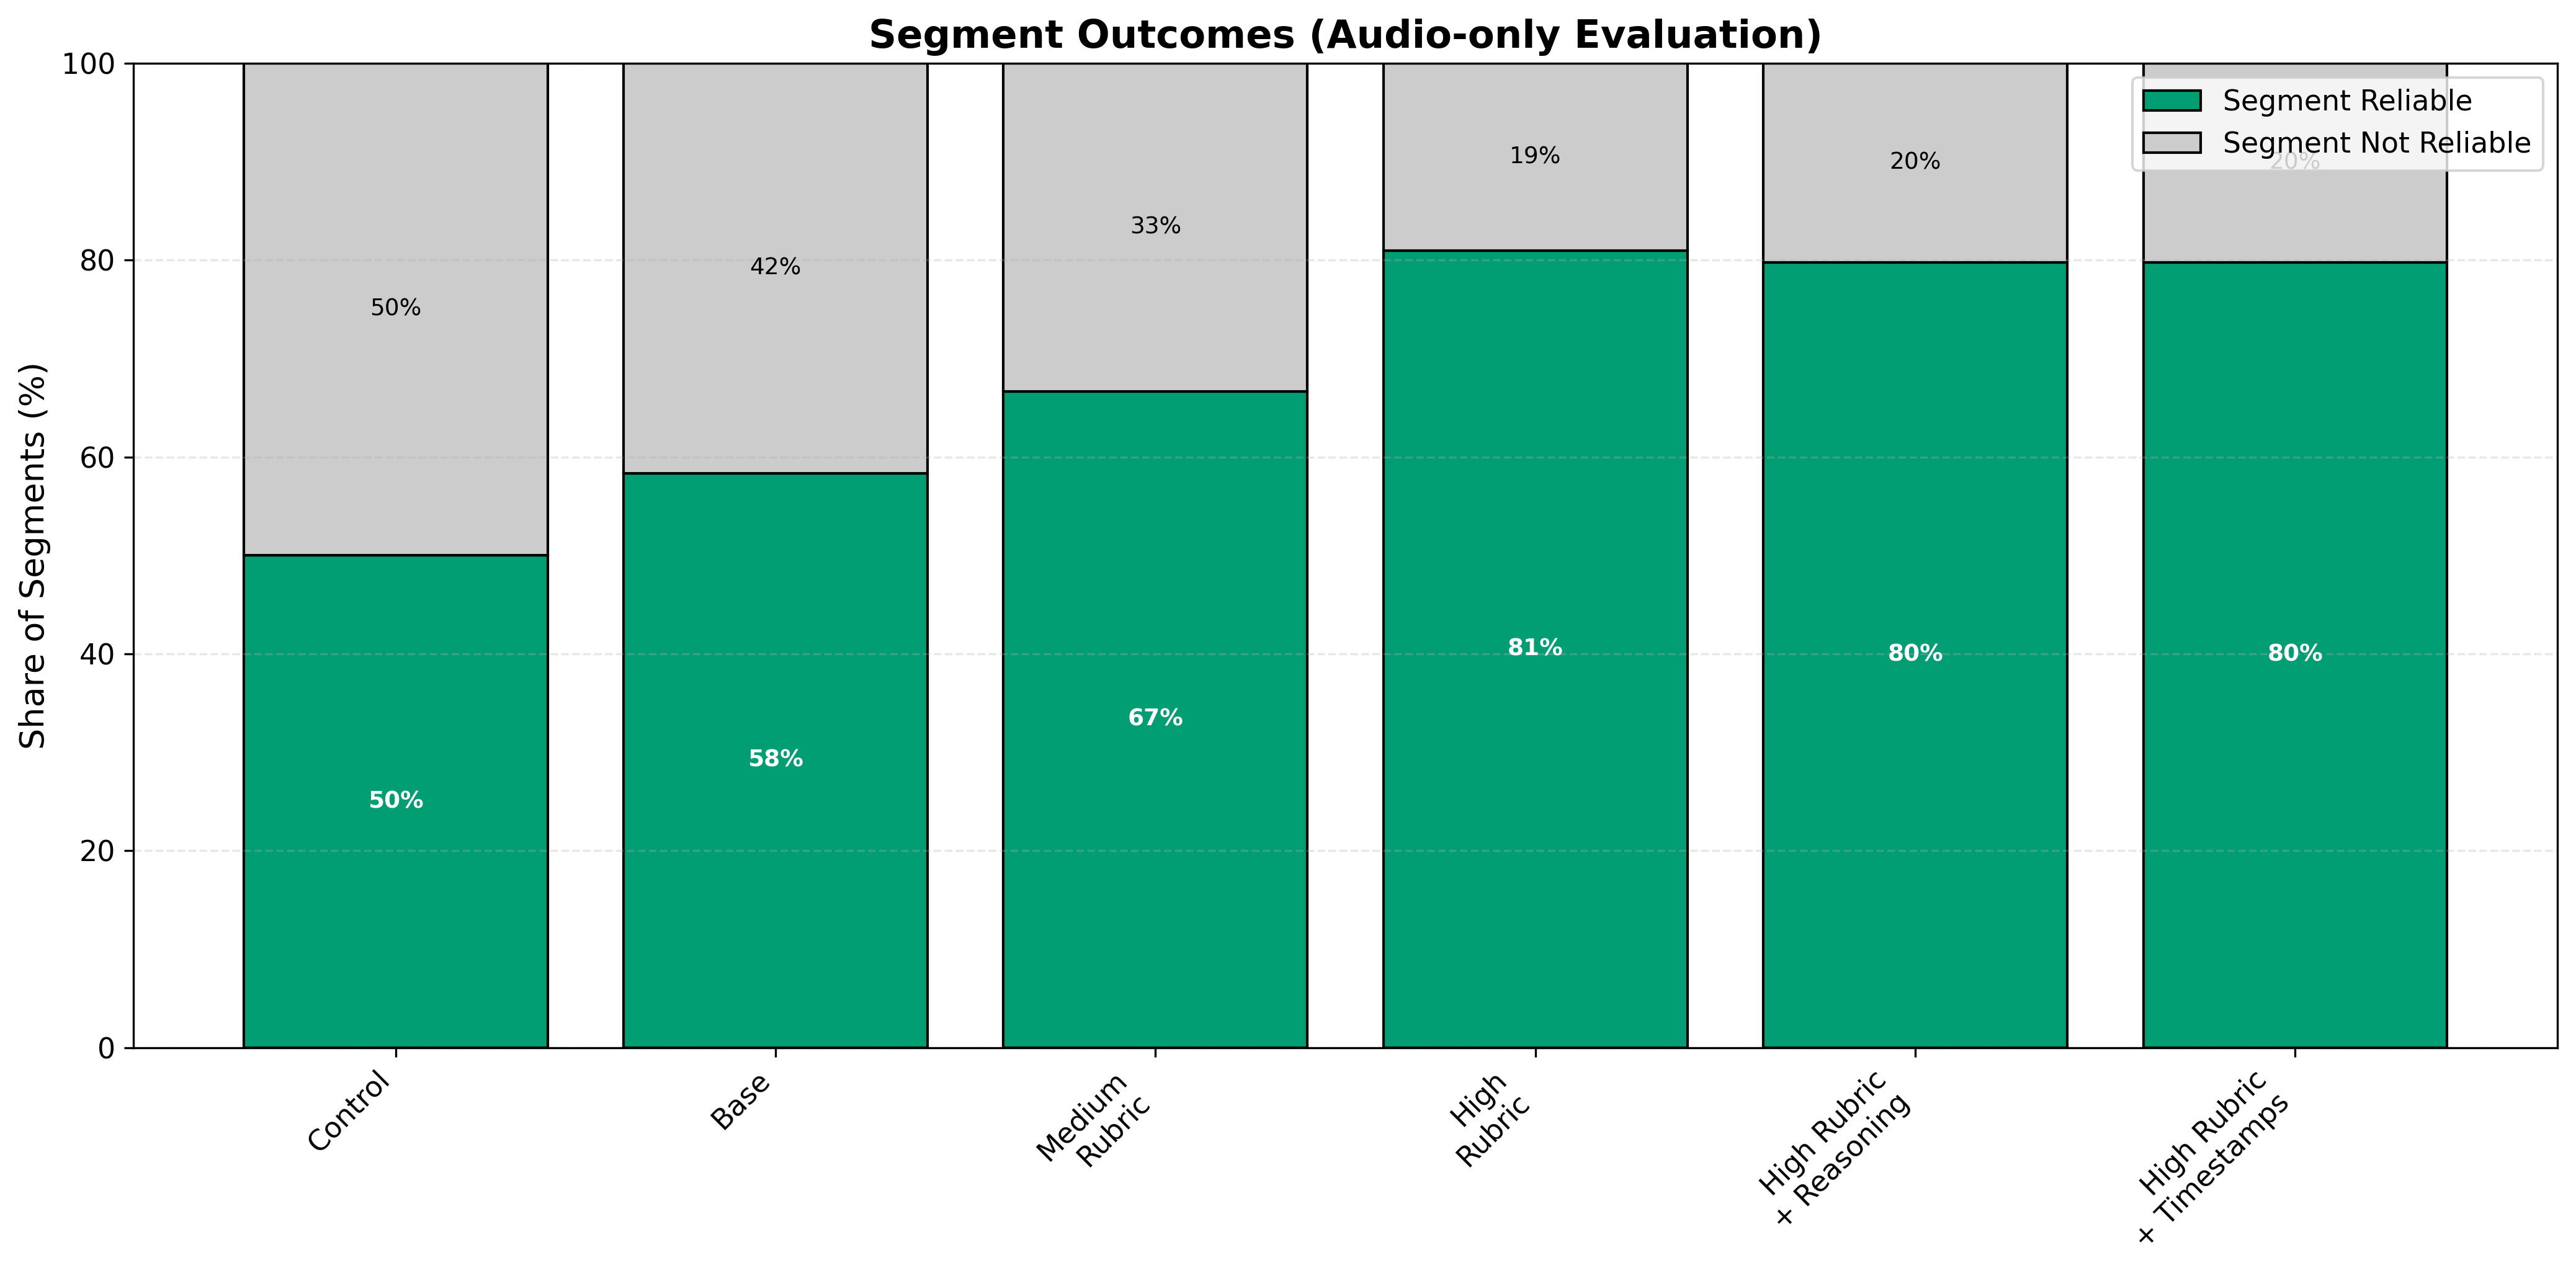

📊 Segment outcomes chart generated & saved.


In [69]:
# --- Segment outcomes (UPDATED — ToL removed) ---------------------------------
fig, ax = plt.subplots(figsize=(14, 7))

x         = np.arange(len(model_labels))
seg_pass  = reliability_df['Segment Pass Rate'] * 100
seg_fail  = 100 - seg_pass

ax.bar(x, seg_pass,
       label='Segment Reliable',
       color=COLOR_PALETTE[2],
       edgecolor='black')
ax.bar(x, seg_fail,
       bottom=seg_pass,
       label='Segment Not Reliable',
       color='#CCCCCC',
       edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(model_labels, rotation=45, ha='right')
ax.set_ylabel('Share of Segments (%)', fontsize=13)
ax.set_title('Segment Outcomes (Audio-only Evaluation)', fontsize=15, weight='bold')
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend(loc='upper right')

# Annotate bars
for i, p in enumerate(seg_pass):
    ax.text(i, p / 2,              f'{p:.0f}%', ha='center', va='center',
            color='white', weight='bold', fontsize=9)
    ax.text(i, p + seg_fail[i] / 2, f'{seg_fail[i]:.0f}%', ha='center',
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig('segment_outcomes_stacked.png',  dpi=300, bbox_inches='tight')
plt.savefig('segment_outcomes_stacked.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Segment outcomes chart generated & saved.")


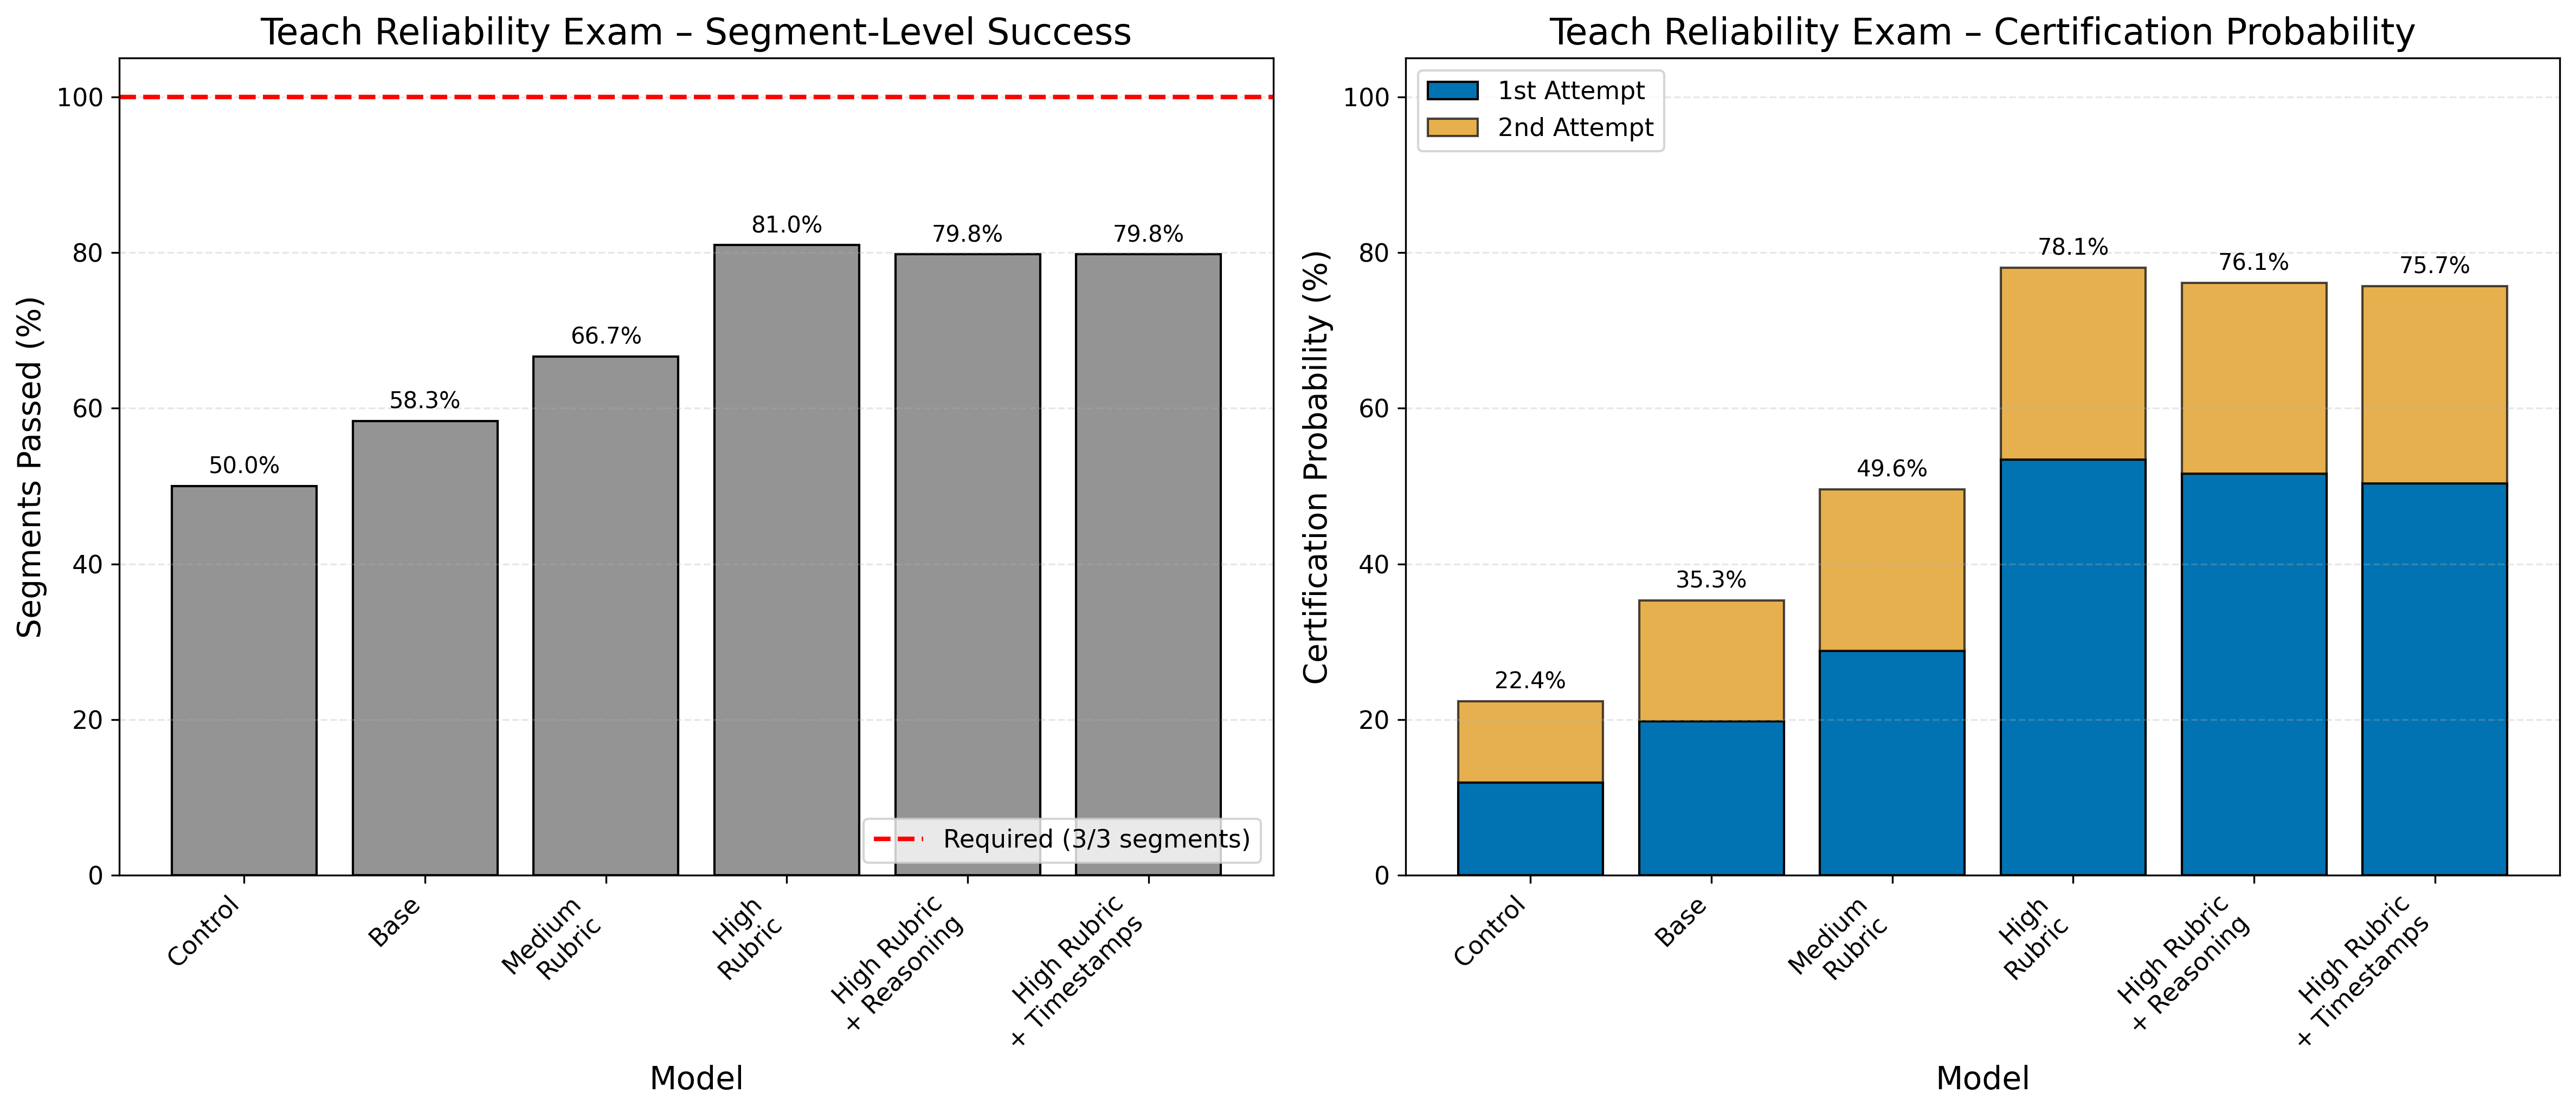

Reliability exam visualization saved (updated logic).


In [80]:
# --- Reliability Exam Visualisation (UPDATED) -------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# ----- Panel A : segment pass rate (must be 100 %) --------------------------
x = np.arange(len(model_labels))
pass_rates = reliability_df['Segment Pass Rate'] * 100

bars = ax1.bar(
    x,
    pass_rates,
    color=[COLOR_PALETTE[2] if rate == 100 else COLOR_PALETTE[5] for rate in pass_rates],
    edgecolor='black',
    linewidth=1
)

ax1.axhline(100, color='red', linestyle='--', linewidth=2, label='Required (3/3 segments)')

ax1.set(
    xlabel='Model',
    ylabel='Segments Passed (%)',
    title='Teach Reliability Exam – Segment-Level Success'
)
ax1.set_xticks(x)
ax1.set_xticklabels(model_labels, rotation=45, ha='right')
ax1.set_ylim(0, 105)
ax1.grid(axis='y', linestyle='--', alpha=0.3)
ax1.legend(loc='lower right')

for bar, rate in zip(bars, pass_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, rate + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

# ----- Panel B : certification probability ----------------------------------
first_try_pct = reliability_df['First Try Prob'] * 100
second_pct    = (reliability_df['Two Try Prob'] - reliability_df['First Try Prob']) * 100

ax2.bar(x, first_try_pct,
        label='1st Attempt',
        color=COLOR_PALETTE[0],
        edgecolor='black', linewidth=1)
ax2.bar(x, second_pct,
        bottom=first_try_pct,
        label='2nd Attempt',
        color=COLOR_PALETTE[1],
        edgecolor='black', linewidth=1, alpha=0.7)

ax2.set(
    xlabel='Model',
    ylabel='Certification Probability (%)',
    title='Teach Reliability Exam – Certification Probability'
)
ax2.set_xticks(x)
ax2.set_xticklabels(model_labels, rotation=45, ha='right')
ax2.set_ylim(0, 105)
ax2.grid(axis='y', linestyle='--', alpha=0.3)
ax2.legend(loc='upper left')

for i, total in enumerate(reliability_df['Two Try Prob'] * 100):
    ax2.text(i, total + 1, f'{total:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('reliability_exam_performance.png', bbox_inches='tight', dpi=300)
plt.savefig('reliability_exam_performance.pdf', bbox_inches='tight', dpi=300)
plt.show()

print("Reliability exam visualization saved (updated logic).")

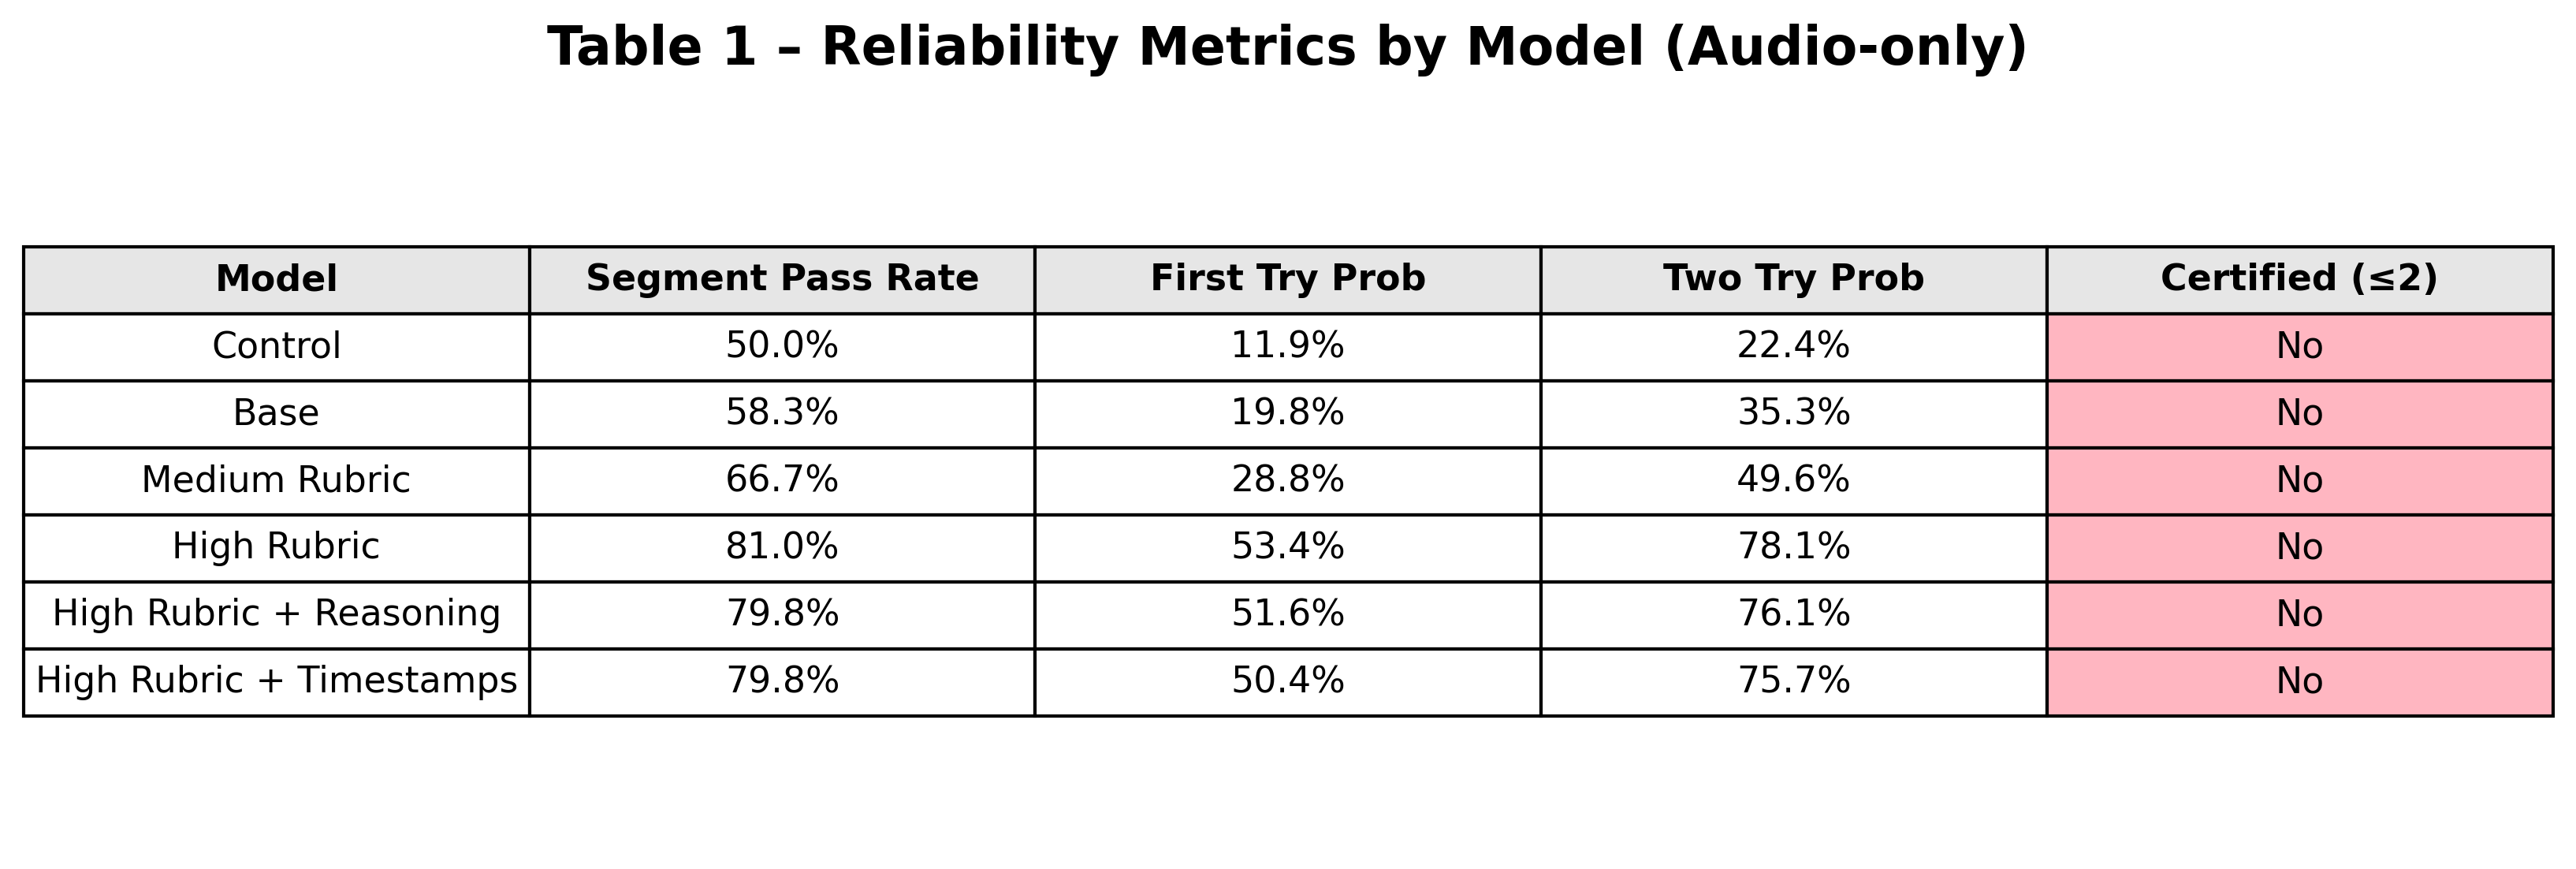

📋 Performance table updated & saved (column name fixed).


In [79]:
# --- Detailed performance metrics table (UPDATED v2 — typo fixed) -------------
tbl_df = reliability_df.copy()
tbl_df['Segment Pass Rate'] = tbl_df['Segment Pass Rate'].apply(lambda v: f"{v*100:.1f}%")
tbl_df['First Try Prob']    = tbl_df['First Try Prob' ].apply(lambda v: f"{v*100:.1f}%")
tbl_df['Two Try Prob']      = tbl_df['Two Try Prob'   ].apply(lambda v: f"{v*100:.1f}%")
tbl_df['Certified (≤2)']    = tbl_df['Two Try Prob'   ].apply(
    lambda p: 'Yes' if float(p.strip('%')) >= 95 else 'No'
)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight'); ax.axis('off')

table = ax.table(cellText=tbl_df.values,
                 colLabels=tbl_df.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.15, 1.7)

# Highlight certification column
cert_col = list(tbl_df.columns).index('Certified (≤2)')
for i in range(len(tbl_df)):
    cell = table[(i + 1, cert_col)]
    cell.set_facecolor('#90EE90' if tbl_df.iloc[i]['Certified (≤2)'] == 'Yes'
                       else '#FFB6C1')

# Style header row
for j in range(len(tbl_df.columns)):
    table[(0, j)].set_facecolor('#E6E6E6')
    table[(0, j)].set_text_props(weight='bold')

plt.title('Table 1 – Reliability Metrics by Model (Audio-only)',
          fontsize=16, weight='bold', pad=16)
plt.savefig('reliability_exam_table.png',  dpi=300, bbox_inches='tight')
plt.savefig('reliability_exam_table.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("📋 Performance table updated & saved (column name fixed).")


## 4. Statistical Significance Visualizations

This section visualizes the results of statistical tests showing which models are significantly different from each other.

In [ ]:
# Compute pairwise statistical comparisons (UPDATED — uses segment_reliable) ---
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.contingency_tables import mcnemar

# Build pass/fail vectors for each model
model_passes = {}
for eval_path, model_label in zip(eval_paths, model_labels):
    model_df = pd.read_csv(eval_path)
    merged   = model_df.merge(human_df, on='School_Clip',
                              suffixes=('_model', '_human'))

    passes = []
    for _, row in merged.iterrows():
        row_m = row[[c + '_model' for c in DOMAIN_COLS]]
        row_h = row[[c + '_human' for c in DOMAIN_COLS]]
        row_m.index = DOMAIN_COLS
        row_h.index = DOMAIN_COLS
        passes.append(segment_reliable(row_m, row_h))

    model_passes[model_label.replace('\n', ' ')] = np.array(passes, dtype=bool)

# McNemar pairwise tests
n_models  = len(model_labels)
p_values  = np.ones((n_models, n_models))
names     = [m.replace('\n', ' ') for m in model_labels]

for i in range(n_models):
    for j in range(i + 1, n_models):
        tbl = pd.crosstab(model_passes[names[i]],
                          model_passes[names[j]])
        if tbl.shape == (2, 2):
            res            = mcnemar(tbl.values, exact=False, correction=True)
            p_values[i, j] = p_values[j, i] = res.pvalue

# Bonferroni correction
n_comp               = (n_models * (n_models - 1)) // 2
alpha                = 0.05
bonferroni_threshold = alpha / n_comp

print(f"Computed {n_comp} pairwise comparisons.")
print(f"Bonferroni-corrected significance threshold: {bonferroni_threshold:.4f}")


Computed 15 pairwise comparisons.
Bonferroni-corrected significance threshold: 0.0033


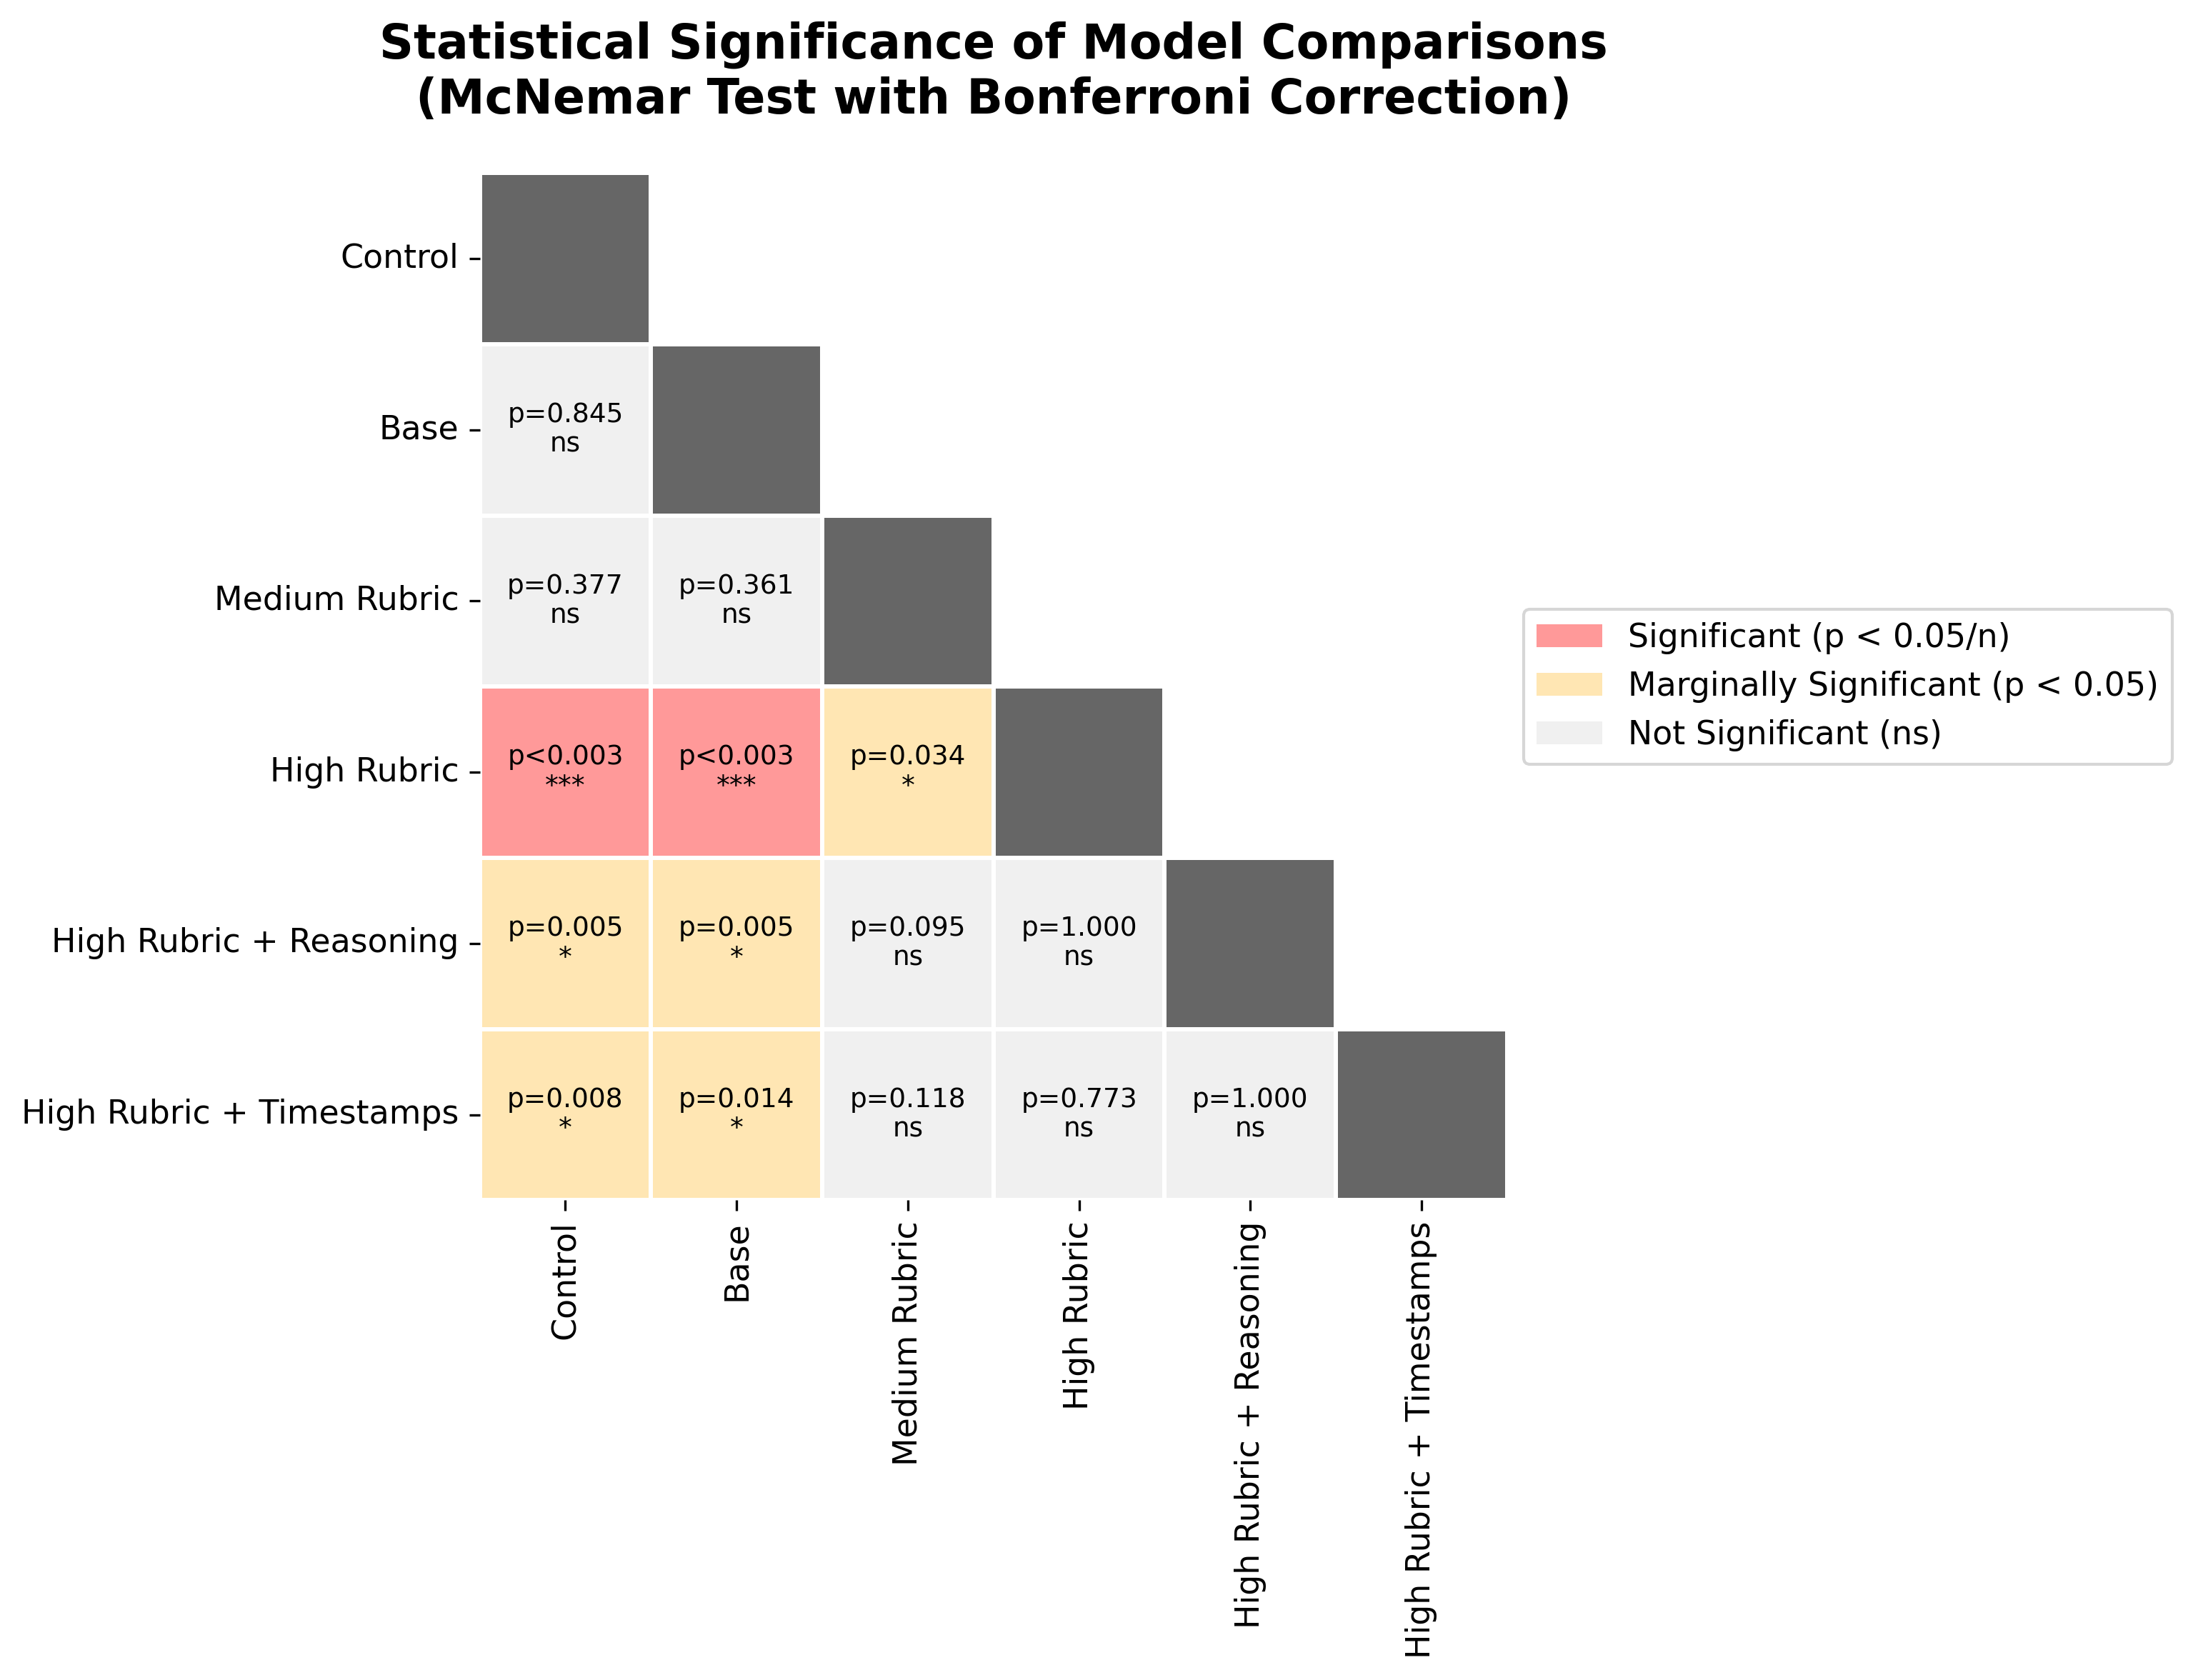

Statistical significance visualization saved.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# Create statistical significance heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Create significance matrix
sig_matrix = np.zeros((n_models, n_models))
for i in range(n_models):
    for j in range(n_models):
        if i == j:
            sig_matrix[i, j] = -1  # Diagonal
        elif p_values[i, j] < bonferroni_threshold:
            sig_matrix[i, j] = 2  # Significant
        elif p_values[i, j] < 0.05:
            sig_matrix[i, j] = 1  # Marginally significant
        else:
            sig_matrix[i, j] = 0  # Not significant

# Define colors for each category
diag_color = '#666666'
ns_color = '#F0F0F0'
marginal_color = '#FFE6B3'
significant_color = '#FF9999'

# Create discrete colormap and normalization
cmap = ListedColormap([diag_color, ns_color, marginal_color, significant_color])
boundaries = [-1.5, -0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(boundaries, cmap.N)

# Mask upper triangle (we only display lower triangle)
mask = np.zeros_like(sig_matrix, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap with discrete colors
sns.heatmap(
    sig_matrix,
    mask=mask,
    cmap=cmap,
    norm=norm,
    square=True,
    linewidths=1,
    cbar=False,
    xticklabels=model_names_clean,
    yticklabels=model_names_clean,
    ax=ax
)

# Add annotations for p-values
for i in range(n_models):
    for j in range(i):
        p_val = p_values[i, j]
        if p_val < bonferroni_threshold:
            text = f'p<{bonferroni_threshold:.3f}\n***'
        elif p_val < 0.001:
            text = f'p={p_val:.3f}\n**'
        elif p_val < 0.05:
            text = f'p={p_val:.3f}\n*'
        else:
            text = f'p={p_val:.3f}\nns'
        ax.text(
            j + 0.5,
            i + 0.5,
            text,
            ha='center',
            va='center',
            fontsize=9,
            color='black'
        )

# Title
ax.set_title(
    'Statistical Significance of Model Comparisons\n(McNemar Test with Bonferroni Correction)',
    fontsize=16,
    fontweight='bold',
    pad=20
)

# Legend for discrete categories
legend_elements = [
    Patch(facecolor=significant_color, label='Significant (p < 0.05/n)'),
    Patch(facecolor=marginal_color, label='Marginally Significant (p < 0.05)'),
    Patch(facecolor=ns_color, label='Not Significant (ns)')
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('statistical_significance_matrix.pdf', bbox_inches='tight', dpi=300)
plt.savefig('statistical_significance_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

print("Statistical significance visualization saved.")


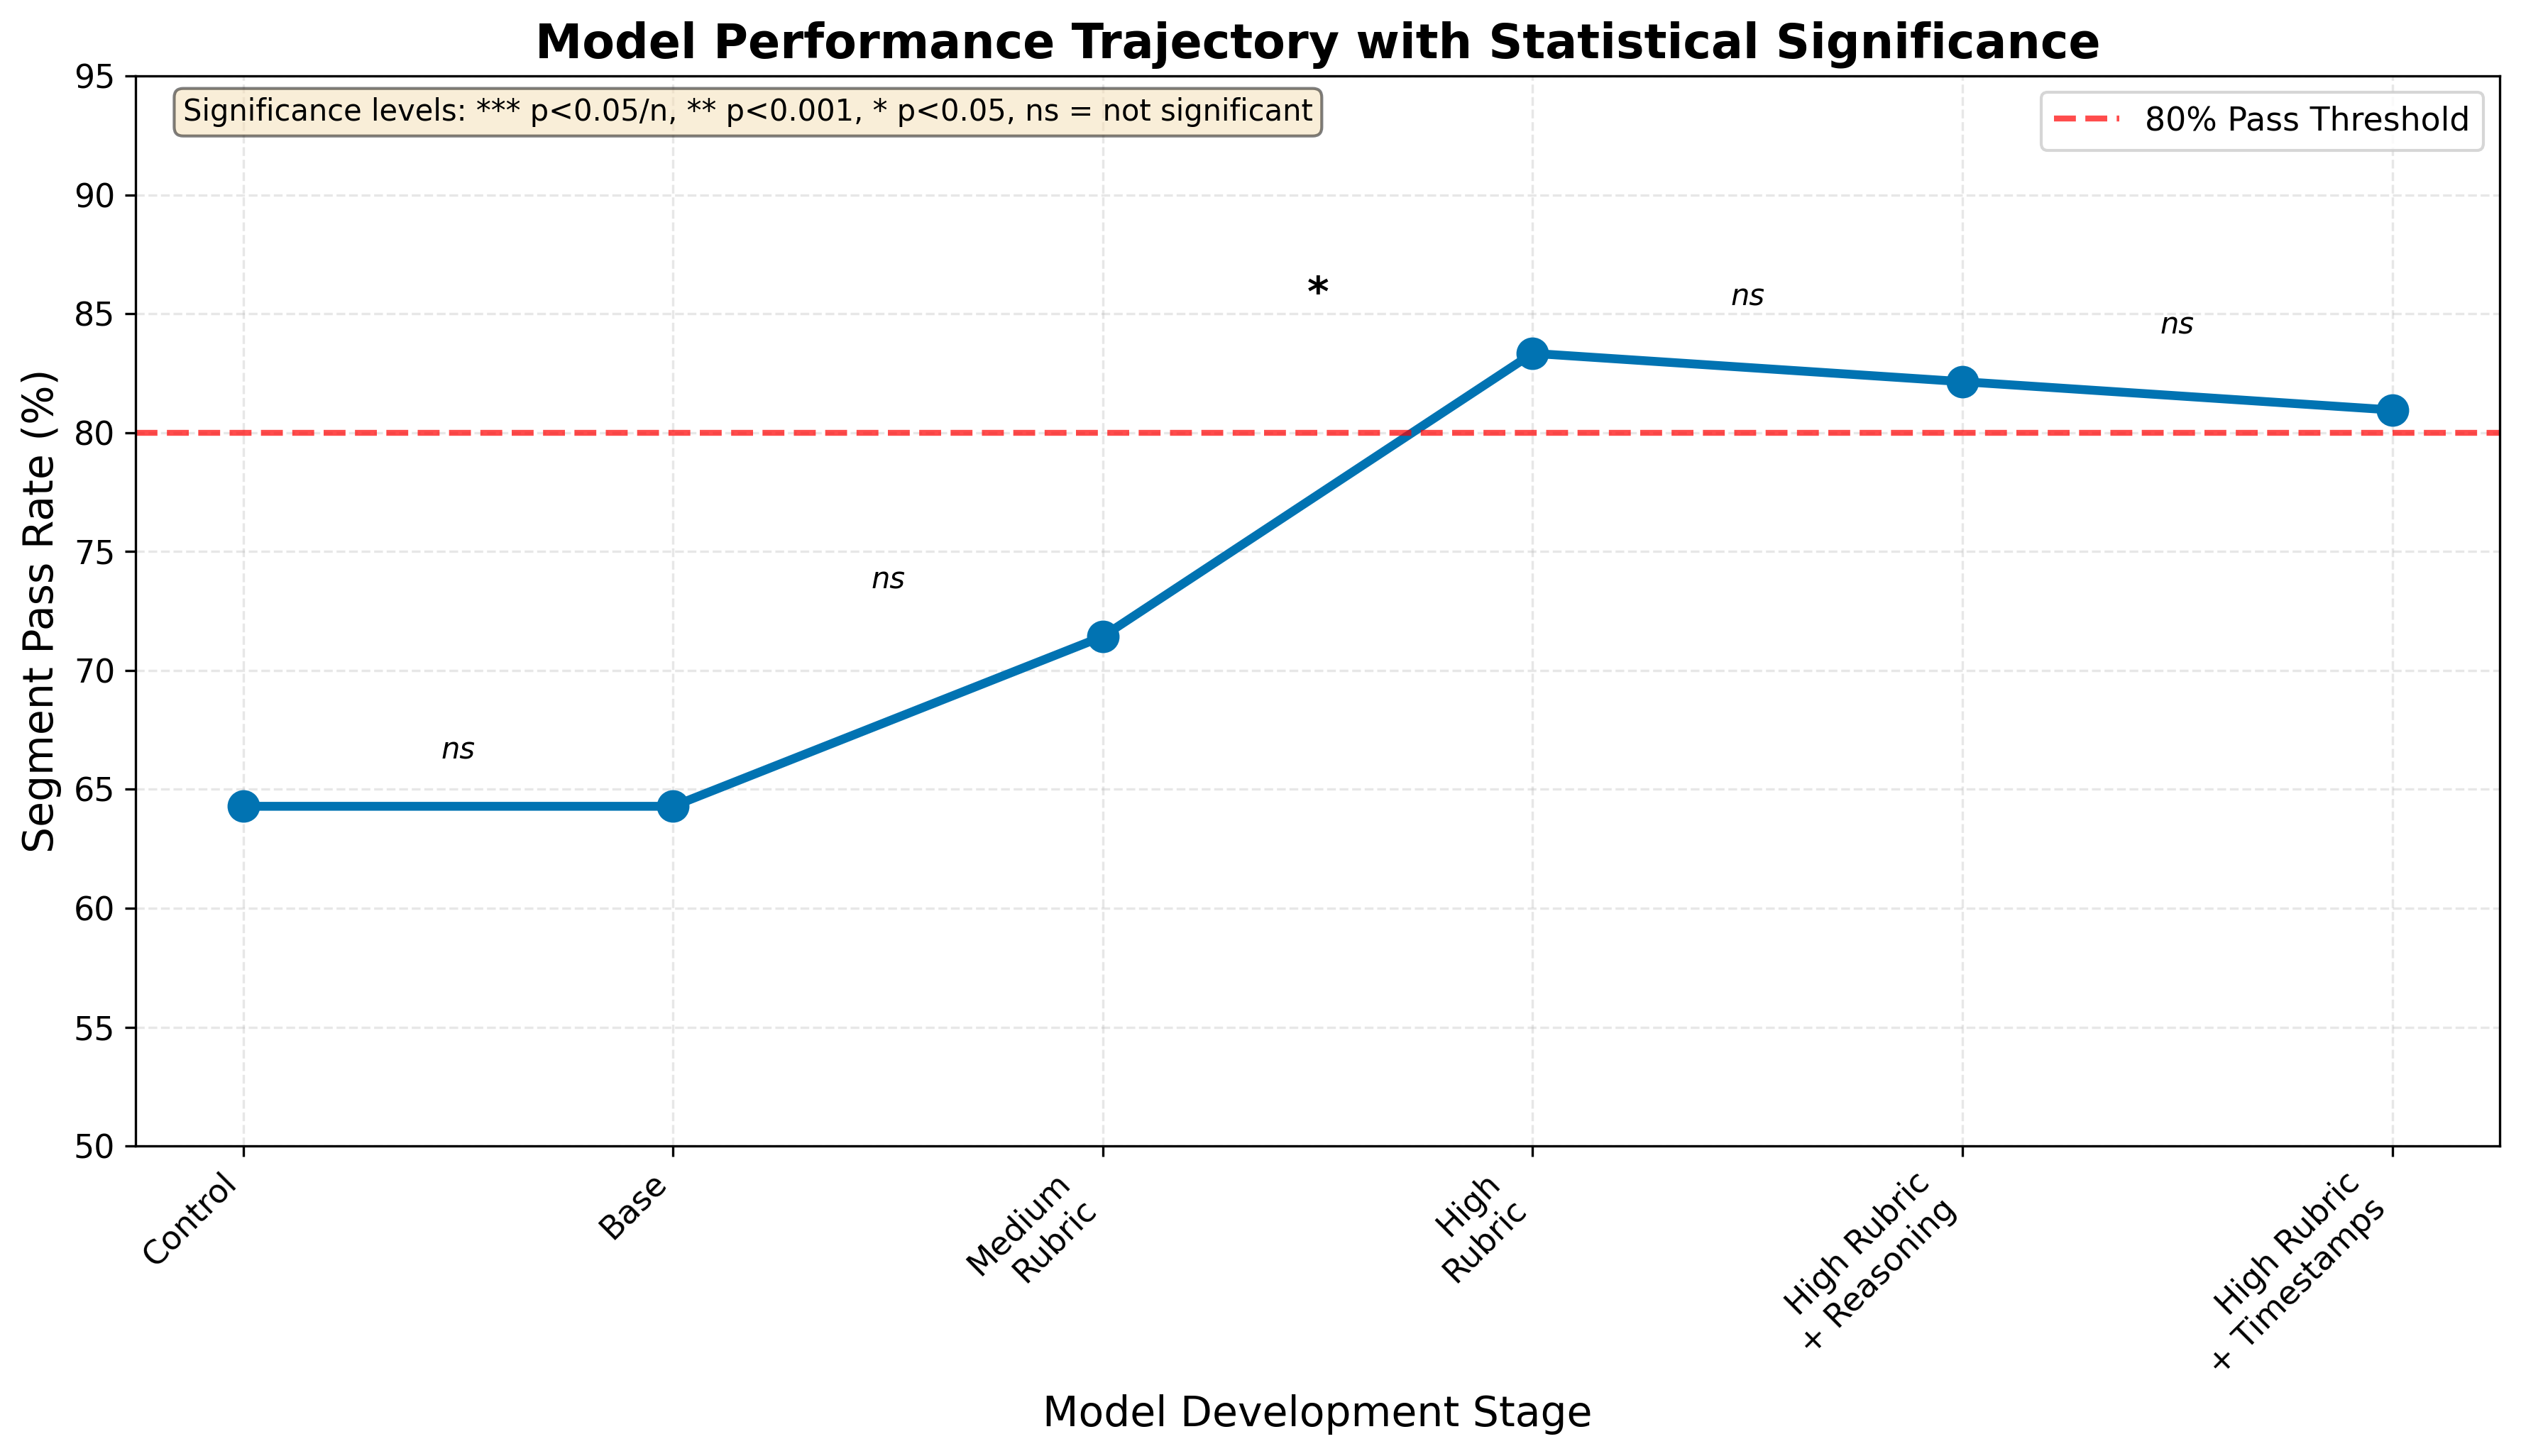

Performance trajectory with significance saved.


In [ ]:
# Create improvement trajectory with significance indicators
fig, ax = plt.subplots(figsize=(12, 7))

# Plot performance trajectory
x = np.arange(len(model_labels))
y = reliability_df['Segment Pass Rate'] * 100

ax.plot(x, y, 'o-', linewidth=3, markersize=10, color=COLOR_PALETTE[0])

# Add significance indicators between consecutive models
for i in range(len(model_labels) - 1):
    p_val = p_values[i, i+1]
    y_pos = max(y[i], y[i+1]) + 2
    
    if p_val < bonferroni_threshold:
        ax.text(i + 0.5, y_pos, '***', ha='center', fontsize=14, fontweight='bold')
    elif p_val < 0.001:
        ax.text(i + 0.5, y_pos, '**', ha='center', fontsize=14, fontweight='bold')
    elif p_val < 0.05:
        ax.text(i + 0.5, y_pos, '*', ha='center', fontsize=14, fontweight='bold')
    else:
        ax.text(i + 0.5, y_pos, 'ns', ha='center', fontsize=10, style='italic')

# Add threshold line
ax.axhline(80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='80% Pass Threshold')

# Formatting
ax.set_xlabel('Model Development Stage', fontsize=14)
ax.set_ylabel('Segment Pass Rate (%)', fontsize=14)
ax.set_title('Model Performance Trajectory with Statistical Significance',
             fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_labels, rotation=45, ha='right')
ax.set_ylim(50, 95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()

# Add annotation
ax.text(0.02, 0.98, 'Significance levels: *** p<0.05/n, ** p<0.001, * p<0.05, ns = not significant',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('performance_trajectory_significance.pdf', bbox_inches='tight', dpi=300)
plt.savefig('performance_trajectory_significance.png', bbox_inches='tight', dpi=300)
plt.show()

print("Performance trajectory with significance saved.")

## 5. Model Specifications Table

This section creates a comprehensive table showing the specifications of each model including rubric version, dataset, and AI model used.

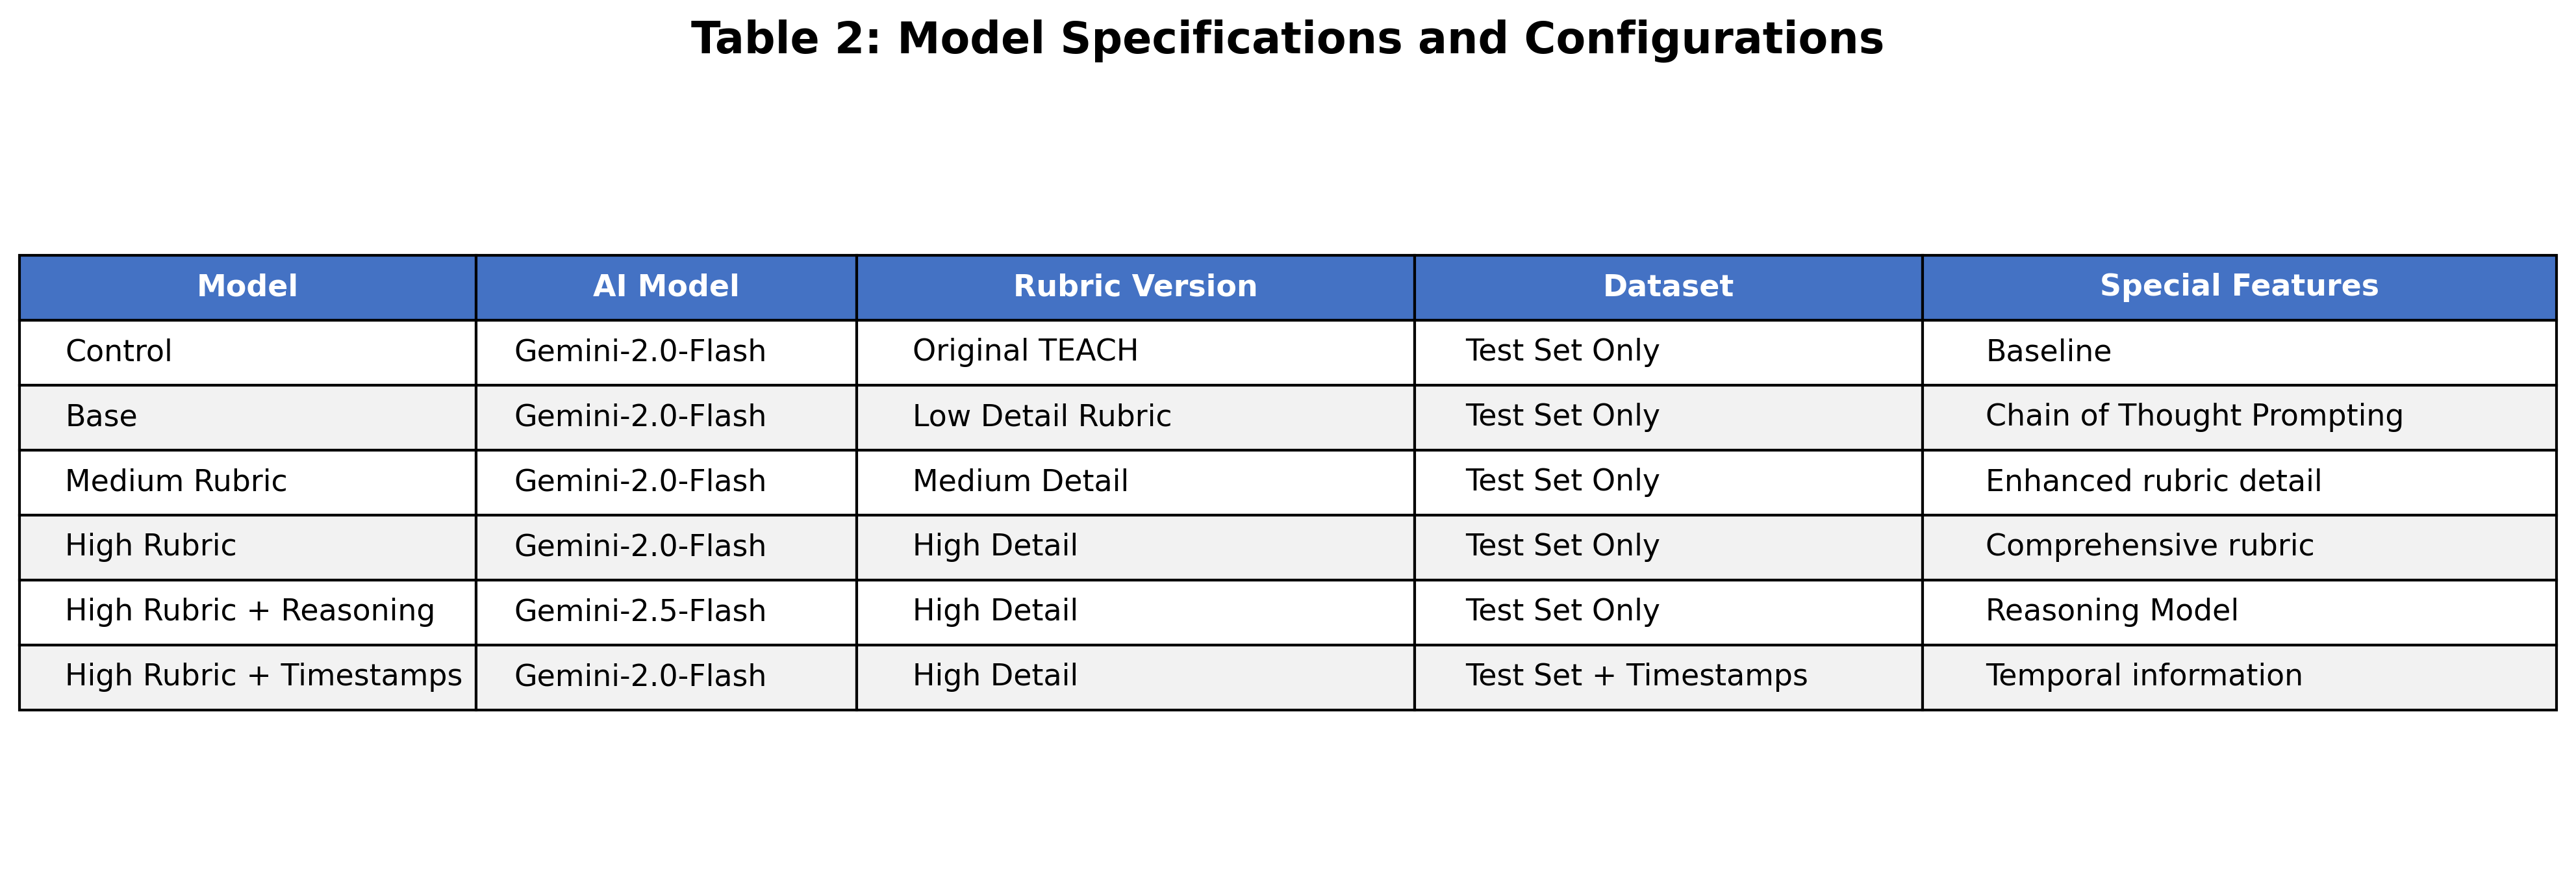

Model specifications table saved.


In [ ]:
# Create model specifications data
model_specs = [
    {
        'Model': 'Control',
        'AI Model': 'Gemini-2.0-Flash',
        'Rubric Version': 'Original TEACH',
        'Dataset': 'Test Set Only',
        'Special Features': 'Baseline'
    },
    {
        'Model': 'Base',
        'AI Model': 'Gemini-2.0-Flash',
        'Rubric Version': 'Low Detail Rubric',
        'Dataset': 'Test Set Only',
        'Special Features': 'Chain of Thought Prompting'
    },
    {
        'Model': 'Medium Rubric',
        'AI Model': 'Gemini-2.0-Flash',
        'Rubric Version': 'Medium Detail',
        'Dataset': 'Test Set Only',
        'Special Features': 'Enhanced rubric detail'
    },
    {
        'Model': 'High Rubric',
        'AI Model': 'Gemini-2.0-Flash',
        'Rubric Version': 'High Detail',
        'Dataset': 'Test Set Only',
        'Special Features': 'Comprehensive rubric'
    },
    {
        'Model': 'High Rubric + Reasoning',
        'AI Model': 'Gemini-2.5-Flash',
        'Rubric Version': 'High Detail',
        'Dataset': 'Test Set Only',
        'Special Features': 'Reasoning Model'
    },
    {
        'Model': 'High Rubric + Timestamps',
        'AI Model': 'Gemini-2.0-Flash',
        'Rubric Version': 'High Detail',
        'Dataset': 'Test Set + Timestamps',
        'Special Features': 'Temporal information'
    }
]

specs_df = pd.DataFrame(model_specs)

# Create specifications table
fig, ax = plt.subplots(figsize=(14, 5))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=specs_df.values,
                colLabels=specs_df.columns,
                cellLoc='left',
                loc='center',
                colWidths=[0.18, 0.15, 0.22, 0.20, 0.25])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2.0)

# Style header row
for j in range(len(specs_df.columns)):
    table[(0, j)].set_facecolor('#4472C4')
    table[(0, j)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(specs_df) + 1):
    if i % 2 == 0:
        for j in range(len(specs_df.columns)):
            table[(i, j)].set_facecolor('#F2F2F2')

plt.title('Table 2: Model Specifications and Configurations',
          fontsize=16, fontweight='bold', pad=20)
plt.savefig('model_specifications_table.pdf', bbox_inches='tight', dpi=300)
plt.savefig('model_specifications_table.png', bbox_inches='tight', dpi=300)
plt.show()

print("Model specifications table saved.")

## 6. Export All Figures for Publication

This section ensures all figures are saved in high-resolution formats suitable for academic publication.

In [ ]:
# Create summary of all generated figures
print("\n" + "="*60)
print("PUBLICATION-READY FIGURES GENERATED:")
print("="*60)
print("\n1. Domain Accuracy Analysis:")
print("   - domain_accuracy_analysis.pdf/.png")
print("   - Shows strict and within-one accuracy for all 9 domains")
print("\n2. Reliability Exam Performance:")
print("   - reliability_exam_performance.pdf/.png")
print("   - Shows segment pass rates and certification probabilities")
print("\n3. Performance Table:")
print("   - reliability_exam_table.pdf/.png")
print("   - Detailed metrics table with pass/fail classification")
print("\n4. Statistical Significance Matrix:")
print("   - statistical_significance_matrix.pdf/.png")
print("   - Pairwise model comparisons with Bonferroni correction")
print("\n5. Performance Trajectory:")
print("   - performance_trajectory_significance.pdf/.png")
print("   - Model improvement with significance indicators")
print("\n6. Model Specifications:")
print("   - model_specifications_table.pdf/.png")
print("   - Technical specifications for each model")
print("\n" + "="*60)
print("\nAll figures saved in both PDF and PNG formats at 300 DPI.")
print("Figures are formatted for direct inclusion in academic manuscripts.")


PUBLICATION-READY FIGURES GENERATED:

1. Domain Accuracy Analysis:
   - domain_accuracy_analysis.pdf/.png
   - Shows strict and within-one accuracy for all 9 domains

2. Reliability Exam Performance:
   - reliability_exam_performance.pdf/.png
   - Shows segment pass rates and certification probabilities

3. Performance Table:
   - reliability_exam_table.pdf/.png
   - Detailed metrics table with pass/fail classification

4. Statistical Significance Matrix:
   - statistical_significance_matrix.pdf/.png
   - Pairwise model comparisons with Bonferroni correction

5. Performance Trajectory:
   - performance_trajectory_significance.pdf/.png
   - Model improvement with significance indicators

6. Model Specifications:
   - model_specifications_table.pdf/.png
   - Technical specifications for each model


All figures saved in both PDF and PNG formats at 300 DPI.
Figures are formatted for direct inclusion in academic manuscripts.


In [ ]:
# Generate LaTeX code for including figures
print("\n" + "="*60)
print("LATEX CODE FOR MANUSCRIPT INCLUSION:")
print("="*60)
print("""
% Figure 1: Domain Accuracy Analysis
\\begin{figure}[htbp]
\\centering
\\includegraphics[width=\\textwidth]{domain_accuracy_analysis.pdf}
\\caption{Domain-level accuracy comparison across AI evaluator models. Bars show exact agreement (dark) and within-one agreement (light) rates for each of the nine TEACH quality domains.}
\\label{fig:domain_accuracy}
\\end{figure}

% Figure 2: Reliability Exam Performance
\\begin{figure}[htbp]
\\centering
\\includegraphics[width=\\textwidth]{reliability_exam_performance.pdf}
\\caption{TEACH reliability exam performance. (a) Segment pass rates with 80\\% threshold. (b) Certification probability in first and second attempts.}
\\label{fig:reliability_exam}
\\end{figure}

% Table 1: Performance Metrics
\\begin{table}[htbp]
\\centering
\\includegraphics[width=0.8\\textwidth]{reliability_exam_table.pdf}
\\caption{Reliability exam performance metrics by model}
\\label{tab:performance}
\\end{table}

% Figure 3: Statistical Significance
\\begin{figure}[htbp]
\\centering
\\includegraphics[width=0.8\\textwidth]{statistical_significance_matrix.pdf}
\\caption{Statistical significance of pairwise model comparisons using McNemar test with Bonferroni correction (α = 0.05/n).}
\\label{fig:significance}
\\end{figure}

% Table 2: Model Specifications
\\begin{table}[htbp]
\\centering
\\includegraphics[width=\\textwidth]{model_specifications_table.pdf}
\\caption{Technical specifications and configurations of AI evaluator models}
\\label{tab:specifications}
\\end{table}
""")


LATEX CODE FOR MANUSCRIPT INCLUSION:

% Figure 1: Domain Accuracy Analysis
\begin{figure}[htbp]
\centering
\includegraphics[width=\textwidth]{domain_accuracy_analysis.pdf}
\caption{Domain-level accuracy comparison across AI evaluator models. Bars show exact agreement (dark) and within-one agreement (light) rates for each of the nine TEACH quality domains.}
\label{fig:domain_accuracy}
\end{figure}

% Figure 2: Reliability Exam Performance
\begin{figure}[htbp]
\centering
\includegraphics[width=\textwidth]{reliability_exam_performance.pdf}
\caption{TEACH reliability exam performance. (a) Segment pass rates with 80\% threshold. (b) Certification probability in first and second attempts.}
\label{fig:reliability_exam}
\end{figure}

% Table 1: Performance Metrics
\begin{table}[htbp]
\centering
\includegraphics[width=0.8\textwidth]{reliability_exam_table.pdf}
\caption{Reliability exam performance metrics by model}
\label{tab:performance}
\end{table}

% Figure 3: Statistical Significance
\begi